# Where to save in the UK

Me and my partner Shirley want to find somewhere to live in the UK that offers both a cosmopolitan atmosphere and provides enough disposable income to save for further study and trips. The following is a caculation of how much money we would have leftover after deductions and basic living costs in different cities.

## 1. Parameters

The focus of this disposable income analysis can be toggled between combined, Jack's or Shirley's income. Jack's income can also be toggled between location dependent or independent work given a potential opportunity to work remotely. Various costs assumptions can also be adjusted.

In [1]:
# bases the analysis on either: 'jack', 'shirley' or 'combined'
focus = 'combined'

# bases jack's income on whether his job is 'location_dependent' or 'location_independent'
jack_income = 'location_dependent'

# upper and lower estimates for Jack's monhtly salary if he worked remote
remote_upper, remote_lower = 2666, 2166

# monthly food cost estimate for 2 people
food_costs = 600

# monthly savings needed for Shirley's spouse visa renewal (spread over 2 years)
savings_needed_for_next_visa_app = 175

# monthly savings needed for Shirley's master degree (spread over 2 years) 
savings_needed_for_Shirley_masters = 187.5

## 2. Cities

Creates a dataframe of large UK cities with a cosmopolitan atmosphere. 

In [2]:
import pandas as pd

cities = pd.DataFrame({
    'city': [
        'London',
        'Manchester',
        'Bristol',
        'Liverpool',
        'Brighton',
        'Edinburgh'
    ]
})

## 3. Income

### Salaries

Salaries are estimated using Glassdoor salary ranges with 1-3 years of experience for our respective fields. 

In [3]:
# location dependent values for Shirley (i.e. she would 
# work as a waitress in whatever city we live in. 
cities['waitressing_upper'] = [
    2083, 
    1916, 
    1750, 
    1750,
    1833,
    1833
]
cities['waitressing_lower'] = [
    1416, 
    1333, 
    1333, 
    1333,
    1333,
    1416
]

# location dependent or independent values for Jack (i.e. there 
# is a posibility for him to do remote work with his family. 
if jack_income == 'location_dependent': 
    cities['juniordev_upper'] = [
        3666, 
        2833, 
        2666, 
        2250,
        2500,
        2916
    ]
    cities['juniordev_lower'] = [
        2083, 
        2166, 
        2083, 
        1666,
        1833,
        2250
    ]
elif jack_income == 'location_independent':
    cities['juniordev_upper'] = [remote_upper for x in range(len(cities))]
    cities['juniordev_lower'] = [remote_lower for x in range(len(cities))]
else:
    raise ValueError("'jack_income' must be set to either 'location_dependent' or 'location_independent'")

### Deductions

Deductions are  made for student loan repayments, income tax and national insurance contributions.

In [4]:
# personal allowance
pa = 12570

# basic limit
bl = 50270


def bachelor_deductions(income):
    """
    Calculates deductions for Jack's bachelors loan. 
    """
    if income <= 28470:
        return 0
    else:
        return (income - 28470) * 0.09


def masters_deductions(income):
    """
    Calculates deductions for Jack's masters loan. 
    """
    if income <= 21000:
        return 0
    else:
        return (income - 21000) * 0.06


def income_tax_deductions(income):
    """
    Calculates income tax deductions for Jack and Shirley. 
    """    
    if income <= pa:
        return 0
    elif income <= bl:
        return (income - pa) * 0.20
    else:
        tax = (bl - pa) * 0.20
        tax += (income - bl) * 0.40
        return tax


def national_insurance_deductions(income): 
    """
    Calculates national insurance deductions for Jack and Shirley. 
    """    
    if income <= pa:
        return 0
    elif income <= bl:
        return (income - pa) * 0.08
    else:
        return ((bl - pa) * 0.08 + (income - bl) * 0.02)
        

def shirley_income_after_deductions(monthly_income):
    """
    Calculates Shirley's income after tax and national insurance
    """
    i = monthly_income * 12
    d = income_tax_deductions(i) + national_insurance_deductions(i)
    return (i - d) / 12
    

def jack_income_after_deductions(monthly_income):
    """
    Calculates Jacks's income after student loan repayments, tax and national insurance
    """
    i = monthly_income * 12
    d = bachelor_deductions(i) + masters_deductions(i) + income_tax_deductions(i) + national_insurance_deductions(i)
    return (i - d) / 12

### Adjusted combined income

Calculates combined income after deductions across a range of potential incomes, assuming we earn an equal amount.

In [5]:
import numpy as np

# a range of potential monthly incomes per person
monthly_incomes = np.arange(1250, 3333 + 25, 25, dtype=float)

# calculates combined take home incomes at different potential gross income levels
if focus == 'jack':
    adjusted_income = [jack_income_after_deductions(x) for x in monthly_incomes]
elif focus == 'shirley':
    adjusted_income = [shirley_income_after_deductions(x) for x in monthly_incomes]
elif focus == 'combined':
    adjusted_income = [(shirley_income_after_deductions(x) + jack_income_after_deductions(x)) for x in monthly_incomes]
else:
    raise ValueError("'focus' must be set to either 'shirley', 'jack' or 'combined.'")

## 4. Expenses

### Variable expenses

Rent is the average cost of renting a room according to Spareroom.com. Transport is the cost of a monthly travel pass according to Numbeo. 

In [6]:
cities['rent'] = [
    985, 
    691,
    737,
    555,
    750,
    778
]

cities['transport'] = [
    180, 
    88.48,
    87,
    78,
    98,
    73
]

### Fixed expenses

Food is estimated at 600, loan repayments 356, savings for our next spouse visa application 180 and savings for Shirley's masters 400 per month. 

In [7]:
cities['food'] = [food_costs for x in range(len(cities))]
cities['existing_debt_repayments'] = [356 for x in range(len(cities))]
cities['savings_needed_for_next_visa_app'] = [savings_needed_for_next_visa_app for x in range(len(cities))]
cities['savings_needed_for_Shirley_masters'] = [savings_needed_for_Shirley_masters for x in range(len(cities))]

### Overall expenses

Overall expenses include both variable and fixed expenses.

In [8]:
# expense columns to be summed for expenses by city
expenses = [
    'rent', 
    'transport', 
    'food', 
    'existing_debt_repayments', 
    'savings_needed_for_next_visa_app', 
    'savings_needed_for_Shirley_masters'
]

# lists overall expenses by city
if focus == 'jack':
    cities['rent'] = cities['rent'] / 2
    cities['food'] = cities['food'] / 2
    cities['existing_debt_repayments'] = cities['existing_debt_repayments'] = 0 
    cities['savings_needed_for_next_visa_app'] = cities['savings_needed_for_next_visa_app'] = 0 
    cities['savings_needed_for_Shirley_masters'] = cities['savings_needed_for_Shirley_masters'] = 0 
    overall_expenses = list(cities[expenses].sum(axis=1))
elif focus == 'shirley':
    cities['rent'] = cities['rent'] / 2
    cities['food'] = cities['food'] / 2
    overall_expenses = list(cities[expenses].sum(axis=1))
else:
    cities['transport'] = cities['transport'] * 2
    overall_expenses = list(cities[expenses].sum(axis=1))

## 5. Visualisation

Visualises estimated disposable income by city.

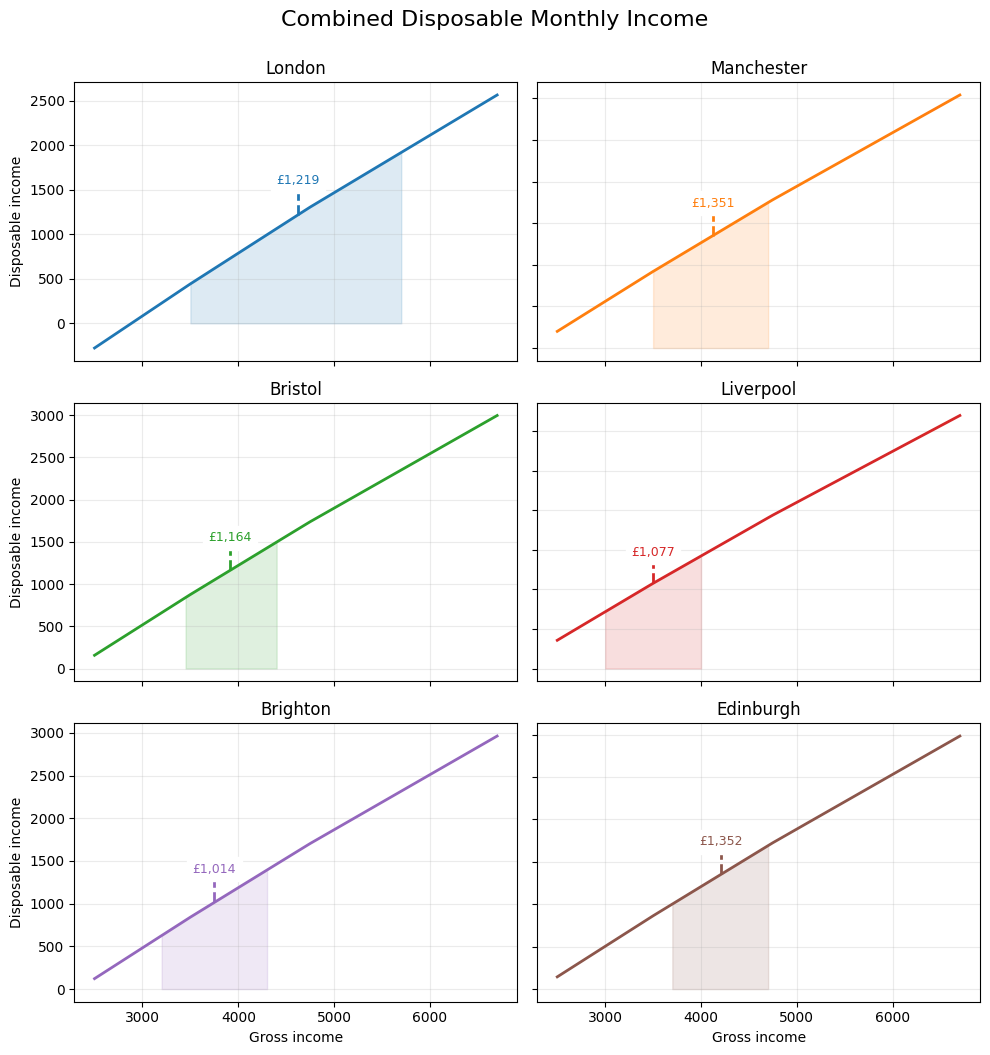

In [9]:
import matplotlib.pyplot as plt

# defines plot parameters
n = len(cities)
ncols = 2
nrows = int(np.ceil(n / ncols))
colors = list(plt.cm.tab10.colors)

# creates a grid of subplots (one per city)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3.5 * nrows))

# creates an overall plot title
fig.suptitle(f'{focus.title()} Disposable Monthly Income', fontsize=16, y=1)

# flattens axes array for easy iteration
axes = np.ravel(axes)

# iterates over subplots, one per city
for i, ax in enumerate(axes):
    
    # defines x
    if focus == 'combined':
        x = monthly_incomes * 2
    else:
        x = monthly_incomes

    # defines y
    y = np.array([x - overall_expenses[i] for x in adjusted_income])

    # plots x against y
    ax.plot(x, y, color=colors[i], linewidth=2)

    # sets upper and lower gross salary estimates based on city
    if focus == 'jack':
        upper = cities.juniordev_upper[i]
        lower = cities.juniordev_lower[i]
    elif focus == 'shirley':
        upper = cities.waitressing_upper[i]
        lower = cities.waitressing_lower[i]
    else:
        upper = cities.waitressing_upper[i] + cities.juniordev_upper[i]
        lower = cities.waitressing_lower[i] + cities.juniordev_lower[i]

    # highlights income range between lower and upper bounds
    mask = (x >= lower) & (x <= upper)
    ax.fill_between(x[mask], y[mask], alpha=0.15, color=colors[i])

    # marks and labels the midpoint of the expected income range
    midpoint = (lower + upper) / 2
    y_mid = np.interp(midpoint, x, y)
    ax.vlines(midpoint, y_mid, y_mid + 300, colors=colors[i], linestyles="dashed", linewidth=2)
    ax.text(midpoint, y_mid + 310, f"£{y_mid:,.0f}", color=colors[i], ha="center", va="bottom", fontsize=9, backgroundcolor="white")

    # sets a title
    ax.set_title(cities.city[i])

    # sets x and y labels
    ax.set_xlabel("Gross income")
    ax.set_ylabel("Disposable income")

    # sets a grid layout
    ax.grid(True, alpha=0.25)

# hides inner labels for clarity
for ax in axes:
    ax.label_outer()

# adjusts plot title spacing
plt.subplots_adjust(top=0.88)

# saves the plot
plt.savefig("monthly_disposable_income.png")

# displays subplots
plt.tight_layout()
plt.show()